In [1]:
using Pkg
Pkg.add(["Random", "Distributions", "Plots", "StatsPlots", "Statistics", "LinearAlgebra"])

    Updating registry at `C:\Users\bowus\.julia\registries\General.toml`
   Resolving package versions...
   Installed Libmount_jll ────────────── v2.40.2+1
   Installed GR_jll ──────────────────── v0.73.10+0
   Installed LERC_jll ────────────────── v4.0.0+2
   Installed JpegTurbo_jll ───────────── v3.1.0+1
   Installed LoggingExtras ───────────── v1.1.0
   Installed OffsetArrays ────────────── v1.15.0
   Installed Calculus ────────────────── v0.5.2
   Installed PlotUtils ───────────────── v1.4.3
   Installed Xorg_libpthread_stubs_jll ─ v0.1.1+2
   Installed Xorg_xkbcomp_jll ────────── v1.4.6+1
   Installed ConcurrentUtilities ─────── v2.4.3
   Installed Unitful ─────────────────── v1.21.1
   Installed NearestNeighbors ────────── v0.4.21
   Installed Libgpg_error_jll ────────── v1.51.0+1
   Installed Fontconfig_jll ──────────── v2.15.0+0
   Installed Xorg_libXinerama_jll ────── v1.1.5+0
   Installed Xorg_libxkbfile_jll ─────── v1.1.2+1
   Installed InvertedIndices ─────────── v1.3.1
  

In [2]:
using Random, Distributions, LinearAlgebra, Statistics, Plots

# Function to generate an AR(1) process
function generate_ar1(T::Int, ρ::Float64, σ::Float64)
    ε = rand(Normal(0, σ), T)  # White noise
    y = zeros(T)
    for t in 2:T
        y[t] = ρ * y[t-1] + ε[t]  # AR(1) recursion
    end
    return y
end

# Function to estimate ρ using OLS
function estimate_rho_ols(y::Vector)
    Y = y[2:end]            # Dependent variable (y_t)
    X = y[1:end-1]          # Independent variable (y_t-1)
    rho_hat =  sum(X .* Y) / sum(X .* X)
    return rho_hat  # OLS estimate: (X'Y) / (X'X)
end




estimate_rho_ols (generic function with 1 method)

In [12]:
# Set the parameters for the AR(1) process
T = 100      # Number of observations
ρ = 0.5      # True AR(1) coefficient
σ = 1.0      # Standard deviation of the white noise
num_simulations = 5000  # Number of Monte Carlo simulations

# Run Monte Carlo simulations
rho_estimates = zeros(num_simulations)

for i in 1:num_simulations
    y = generate_ar1(T, ρ, σ)  # Generate AR(1) data
    rho_estimates[i] = estimate_rho_ols(y)  # Estimate ρ
end
# Plot the distribution of ρ estimates
histogram(rho_estimates, bins=30, alpha=0.6, label="OLS estimates of ρ", legend=:topright,size=(800,600))
vline!([ρ], label="True ρ = $ρ", color=:red)
xlabel!("ρ estimates")
ylabel!("Frequency")
title!("Distribution of OLS Estimates of ρ for T= $T and ρ = $ρ")
# Save the plot as a PNG file
#savefig("rho_estimates_distribution_Q1.png")

"c:\\Users\\bowus\\OneDrive - Emory\\PhD Economics\\Year 2\\Time Series\\Homework\\Assignment 3\\rho_estimates_distribution_Q1.png"

In [31]:
using Statistics

# Adjusted function to compute autocovariance at lag k
function autocovariance(u::Vector, lag::Int)
    T = length(u)
    u_mean = mean(u)
    cov_sum = 0.0
    
    # Compute autocovariance at lag h
    for t in (lag+1):T
        cov_sum += (u[t] - u_mean) * (u[t-lag] - u_mean)
    end
    
    # Normalize by the number of observations (subtract 1 for unbiased estimate)
    return cov_sum / (T - lag)
end

# Main HAC estimator using Newey-West correction
function newey_west_se(y::Vector, ρ_hat::Float64, M::Int)
    T = length(y)
    Y = y[2:end]            # Dependent variable (y_t)
    X = y[1:end-1]          # Independent variable (y_{t-1})
    
    # Residuals from OLS estimate
    e_t = Y - ρ_hat * X
    u_t = e_t .* X          # Residuals multiplied by regressors (as per HAC formula)
    
    # Initialize Newey-West variance
    γ_0 = sum(u_t .^ 2) / T # Lag-zero variance
    nw_variance = γ_0       # Start with lag-zero term
    
    # Add terms for each lag up to M
    for h in 1:M
        γ_h = autocovariance(u_t, h)
        weight = 1 - h / (M + 1)  # Newey-West weight
        nw_variance += 2 * weight * γ_h  # Add weighted lagged autocovariances
    end
    
    # Compute HAC variance
    Q = 1/T * sum(X .^ 2)   # Sum of squared regressors
    V_hat = (1/Q) * nw_variance * (1/Q)  # Newey-West HAC variance
    
    return sqrt(V_hat)
end

# Example usage with AR(1) data
y = generate_ar1(100, 0.5, 1.0)  # Generate AR(1) data
ρ_hat = estimate_rho_ols(y)      # OLS estimate for ρ
M = 5                            # Maximum lag for Newey-West

# Compute Newey-West HAC variance
nw_se = newey_west_se(y, ρ_hat, M)
println("Newey-West HAC SE: ", nw_var)


Newey-West HAC SE: 0.6762540847026696


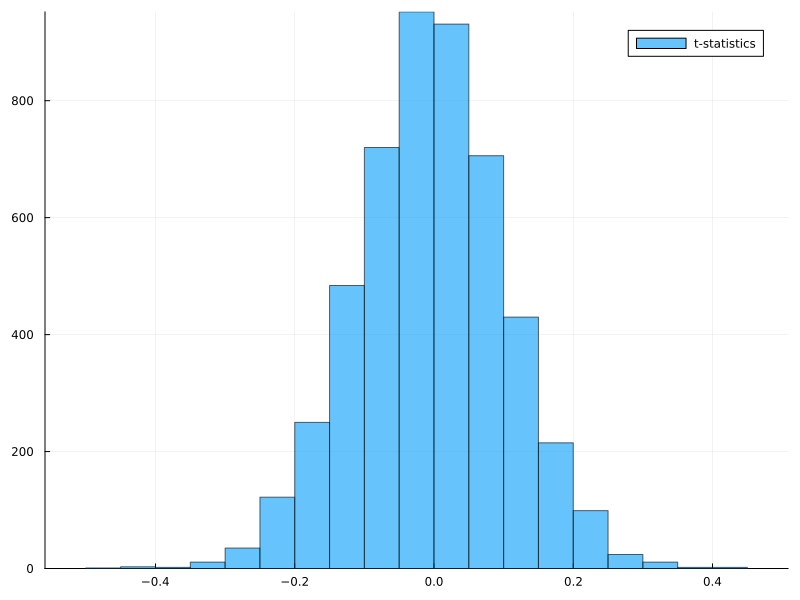

In [36]:
# Run Monte Carlo simulations
#Set the parameters for the AR(1) process
    T = 100      # Number of observations
    ρ = 0.5      # True AR(1) coefficient
    σ = 1.0      # Standard deviation of the white noise
    num_simulations = 5000  # Number of Monte Carlo simulations
t_stat = zeros(num_simulations)
lag = 1

for i in 1:num_simulations
    y = generate_ar1(T, ρ, σ)  # Generate AR(1) data
    rho_hat = estimate_rho_ols(y)  # Estimate ρ
    nw_se = newey_west_se(y, rho_hat, lag)  # Compute Newey-West standard error
    t_stat[i] = (rho_hat - ρ) / nw_se  # Compute t-statistic
end
histogram(t_stat, bins=35, alpha=0.6, label="t-statistics", legend=:topright,size=(800,600))
#savefig("T_stat_distribution_Q2.png")


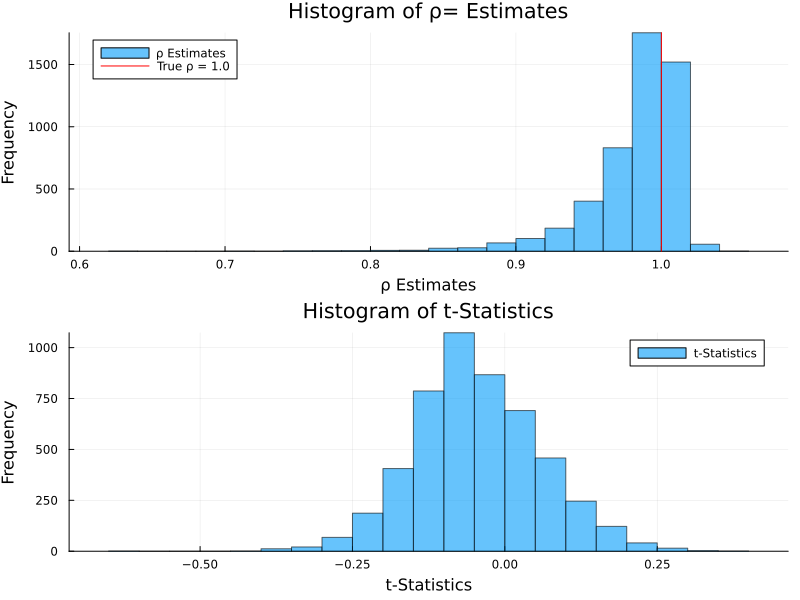

In [53]:
#Set the parameters for the AR(1) process
    T = 100    # Number of observations
    ρ = 1.0    # True AR(1) coefficient
    σ = 1.0     # Standard deviation of the white noise
    num_simulations = 5000  # Number of Monte Carlo simulations
    lag =1

# Run Monte Carlo simulations
rho_estimates = zeros(num_simulations)
t_stat = zeros(num_simulations)

for i in 1:num_simulations
    y = generate_ar1(T, ρ, σ)  # Generate AR(1) data
    rho_estimates[i] = estimate_rho_ols(y)  # Estimate ρ
    nw_se = newey_west_se(y, rho_estimates[i], lag)  # Compute Newey-West standard error
    t_stat[i] = (rho_estimates[i] - ρ) / nw_se  # Compute t-statistic
end

# Create subplots for histograms
p1 = histogram(rho_estimates, bins=35, alpha=0.6, label="ρ Estimates", legend=:topleft,
               xlabel="ρ Estimates", ylabel="Frequency", title="Histogram of ρ= Estimates")
    vline!([ρ], label="True ρ = $ρ", color=:red)

p2 = histogram(t_stat, bins=40, alpha=0.6, label="t-Statistics", legend=:topright,
               xlabel="t-Statistics", ylabel="Frequency", title="Histogram of t-Statistics")

# Combine plots into a single figure
plot(p1, p2, layout=(2, 1), size=(800, 600))
#savefig("rho_t_stat_distribution_Q3.png")

    

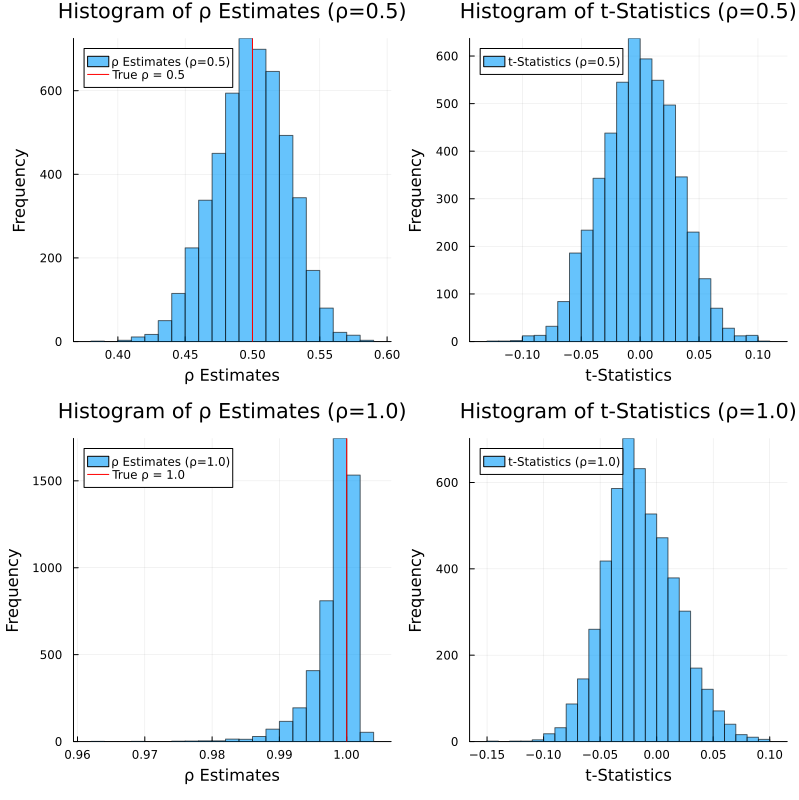

In [56]:
using Random, Distributions, LinearAlgebra, Statistics, Plots

# Function to generate an AR(1) process
function generate_ar1(T::Int, ρ::Float64, σ::Float64)
    ε = rand(Normal(0, σ), T)  # White noise
    y = zeros(T)
    for t in 2:T
        y[t] = ρ * y[t-1] + ε[t]  # AR(1) recursion
    end
    return y
end

# Function to estimate ρ using OLS
function estimate_rho_ols(y::Vector)
    Y = y[2:end]            # Dependent variable (y_t)
    X = y[1:end-1]          # Independent variable (y_t-1)
    rho_hat =  sum(X .* Y) / sum(X .* X)
    return rho_hat  # OLS estimate: (X'Y) / (X'X)
end

# Adjusted function to compute autocovariance at lag k
function autocovariance(u::Vector, lag::Int)
    T = length(u)
    u_mean = mean(u)
    cov_sum = 0.0
    
    # Compute autocovariance at lag h
    for t in (lag+1):T
        cov_sum += (u[t] - u_mean) * (u[t-lag] - u_mean)
    end
    
    # Normalize by the number of observations (subtract 1 for unbiased estimate)
    return cov_sum / (T - lag)
end

# Main HAC estimator using Newey-West correction
function newey_west_se(y::Vector, ρ_hat::Float64, M::Int)
    T = length(y)
    Y = y[2:end]            # Dependent variable (y_t)
    X = y[1:end-1]          # Independent variable (y_{t-1})
    
    # Residuals from OLS estimate
    e_t = Y - ρ_hat * X
    u_t = e_t .* X          # Residuals multiplied by regressors (as per HAC formula)
    
    # Initialize Newey-West variance
    γ_0 = sum(u_t .^ 2) / T # Lag-zero variance
    nw_variance = γ_0       # Start with lag-zero term
    
    # Add terms for each lag up to M
    for h in 1:M
        γ_h = autocovariance(u_t, h)
        weight = 1 - h / (M + 1)  # Newey-West weight
        nw_variance += 2 * weight * γ_h  # Add weighted lagged autocovariances
    end
    
    # Compute HAC variance
    Q = 1/T * sum(X .^ 2)   # Sum of squared regressors
    V_hat = (1/Q) * nw_variance * (1/Q)  # Newey-West HAC variance
    
    return sqrt(V_hat)
end

# Function to run the Monte Carlo simulations
function run_simulation(T, ρ, σ, num_simulations, lag)
    rho_estimates = zeros(num_simulations)
    t_stat = zeros(num_simulations)

    for i in 1:num_simulations
        y = generate_ar1(T, ρ, σ)  # Generate AR(1) data
        rho_estimates[i] = estimate_rho_ols(y)  # Estimate ρ
        nw_se = newey_west_se(y, rho_estimates[i], lag)  # Compute Newey-West standard error
        t_stat[i] = (rho_estimates[i] - ρ) / nw_se  # Compute t-statistic
    end

    return rho_estimates, t_stat
end

# Simulation parameters
T = 1000
σ = 1.0
num_simulations = 5000
lag = 1

# Run simulations for ρ = 0.5 and ρ = 1.0
rho_estimates_0_5, t_stat_0_5 = run_simulation(T, 0.5, σ, num_simulations, lag)
rho_estimates_1_0, t_stat_1_0 = run_simulation(T, 1.0, σ, num_simulations, lag)

# Create subplots
p1 = histogram(rho_estimates_0_5, bins=30, alpha=0.6, label="ρ Estimates (ρ=0.5)", legend=:topleft,
               xlabel="ρ Estimates", ylabel="Frequency", title="Histogram of ρ Estimates (ρ=0.5)")
vline!(p1, [0.5], label="True ρ = 0.5", color=:red)

p2 = histogram(t_stat_0_5, bins=30, alpha=0.6, label="t-Statistics (ρ=0.5)", legend=:topleft,
               xlabel="t-Statistics", ylabel="Frequency", title="Histogram of t-Statistics (ρ=0.5)")

p3 = histogram(rho_estimates_1_0, bins=30, alpha=0.6, label="ρ Estimates (ρ=1.0)", legend=:topleft,
               xlabel="ρ Estimates", ylabel="Frequency", title="Histogram of ρ Estimates (ρ=1.0)")
vline!(p3, [1.0], label="True ρ = 1.0", color=:red)

p4 = histogram(t_stat_1_0, bins=30, alpha=0.6, label="t-Statistics (ρ=1.0)", legend=:topleft,
               xlabel="t-Statistics", ylabel="Frequency", title="Histogram of t-Statistics (ρ=1.0)")

# Combine all plots into a 2x2 layout
plot(p1, p2, p3, p4, layout=(2, 2), size=(800, 800))
#savefig("rho_t_stat_distribution_Q4.png")

In [62]:
using Random, Distributions, LinearAlgebra, Statistics, Plots

# Function to generate an AR(1) process
function generate_ar1(T::Int, ρ::Float64, σ::Float64)
    ε = rand(Normal(0, σ), T)  # White noise
    y = zeros(T)
    for t in 2:T
        y[t] = ρ * y[t-1] + ε[t]  # AR(1) recursion
    end
    return y
end

# Function to estimate ρ using OLS
function estimate_rho_ols(y::Vector)
    Y = y[2:end]            # Dependent variable (y_t)
    X = y[1:end-1]          # Independent variable (y_t-1)
    rho_hat =  sum(X .* Y) / sum(X .* X)
    return rho_hat  # OLS estimate: (X'Y) / (X'X)
end

# Adjusted function to compute autocovariance at lag k
function autocovariance(u::Vector, lag::Int)
    T = length(u)
    u_mean = mean(u)
    cov_sum = 0.0
    
    # Compute autocovariance at lag h
    for t in (lag+1):T
        cov_sum += (u[t] - u_mean) * (u[t-lag] - u_mean)
    end
    
    # Normalize by the number of observations (subtract 1 for unbiased estimate)
    return cov_sum / (T - lag)
end

# Main HAC estimator using Newey-West correction
function newey_west_se(y::Vector, ρ_hat::Float64, M::Int)
    T = length(y)
    Y = y[2:end]            # Dependent variable (y_t)
    X = y[1:end-1]          # Independent variable (y_{t-1})
    
    # Residuals from OLS estimate
    e_t = Y - ρ_hat * X
    u_t = e_t .* X          # Residuals multiplied by regressors (as per HAC formula)
    
    # Initialize Newey-West variance
    γ_0 = sum(u_t .^ 2) / T # Lag-zero variance
    nw_variance = γ_0       # Start with lag-zero term
    
    # Add terms for each lag up to M
    for h in 1:M
        γ_h = autocovariance(u_t, h)
        weight = 1 - h / (M + 1)  # Newey-West weight
        nw_variance += 2 * weight * γ_h  # Add weighted lagged autocovariances
    end
    
    # Compute HAC variance
    Q = 1/T * sum(X .^ 2)   # Sum of squared regressors
    V_hat = (1/Q) * nw_variance * (1/Q)  # Newey-West HAC variance
    
    return sqrt(V_hat)
end

# Function to run the Monte Carlo simulations
function run_simulation(T, ρ, σ, num_simulations, lag)
    rho_estimates = zeros(num_simulations)
    t_stat = zeros(num_simulations)

    for i in 1:num_simulations
        y = generate_ar1(T, ρ, σ)  # Generate AR(1) data
        rho_estimates[i] = estimate_rho_ols(y)  # Estimate ρ
        nw_se = newey_west_se(y, rho_estimates[i], lag)  # Compute Newey-West standard error
        t_stat[i] = (rho_estimates[i] - ρ) / nw_se  # Compute t-statistic
    end

    return rho_estimates, t_stat
end

# Simulation parameters
T = 100
σ = 1.0
num_simulations = 5000
lag = 1

# Run simulations for ρ = 0.5 and ρ = 1.0
rho_estimates_0_5, t_stat_0_5 = run_simulation(T, 0.9, σ, num_simulations, lag)
rho_estimates_1_0, t_stat_1_0 = run_simulation(T, 1.0, σ, num_simulations, lag)

# Create subplots
p1 = histogram(rho_estimates_0_5, bins=30, alpha=0.6, label="ρ Estimates (ρ=0.9)", legend=:topleft,
               xlabel="ρ Estimates", ylabel="Frequency", title="Histogram of ρ Estimates (ρ=0.9)")
vline!(p1, [0.9], label="True ρ = 0.9", color=:red)

p2 = histogram(t_stat_0_5, bins=30, alpha=0.6, label="t-Statistics (ρ=0.9)", legend=:topleft,
               xlabel="t-Statistics", ylabel="Frequency", title="Histogram of t-Statistics (ρ=0.9)")

p3 = histogram(rho_estimates_1_0, bins=30, alpha=0.6, label="ρ Estimates (ρ=0.99)", legend=:topleft,
               xlabel="ρ Estimates", ylabel="Frequency", title="Histogram of ρ Estimates (ρ=0.99)")
vline!(p3, [0.99], label="True ρ = 0.99", color=:red)

p4 = histogram(t_stat_1_0, bins=30, alpha=0.6, label="t-Statistics (ρ=0.99)", legend=:topleft,
               xlabel="t-Statistics", ylabel="Frequency", title="Histogram of t-Statistics (ρ=0.99)")

# Combine all plots into a 2x2 layout
plot(p1, p2, p3, p4, layout=(2, 2), size=(800, 800))
savefig("rho_t_stat_distribution_Q5(T=100).png")


"c:\\Users\\bowus\\OneDrive - Emory\\PhD Economics\\Year 2\\Time Series\\Homework\\Assignment 3\\rho_t_stat_distribution_Q5(T=100).png"

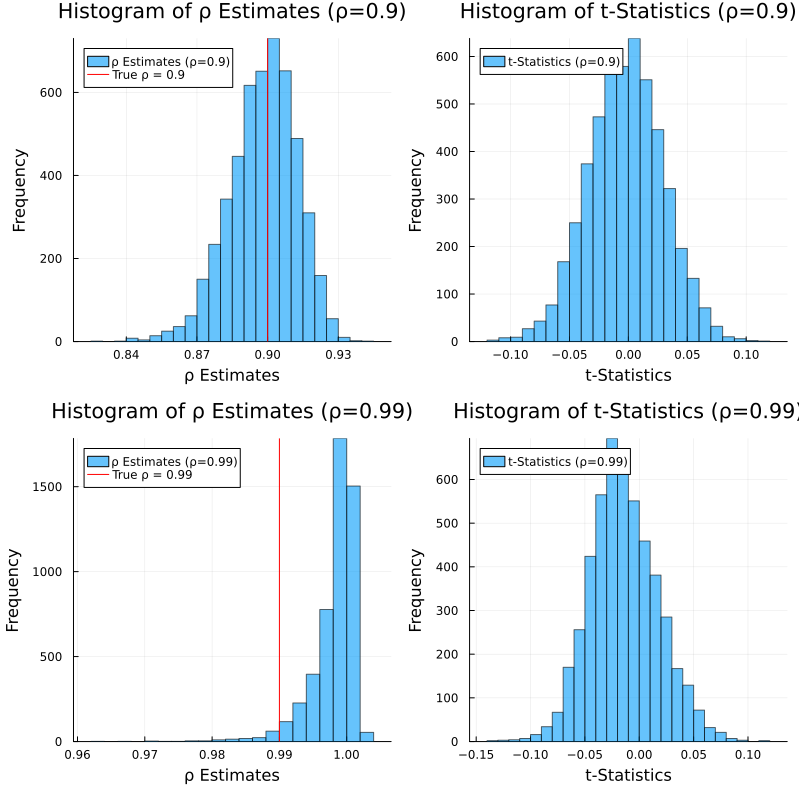

In [63]:
using Random, Distributions, LinearAlgebra, Statistics, Plots

# Function to generate an AR(1) process
function generate_ar1(T::Int, ρ::Float64, σ::Float64)
    ε = rand(Normal(0, σ), T)  # White noise
    y = zeros(T)
    for t in 2:T
        y[t] = ρ * y[t-1] + ε[t]  # AR(1) recursion
    end
    return y
end

# Function to estimate ρ using OLS
function estimate_rho_ols(y::Vector)
    Y = y[2:end]            # Dependent variable (y_t)
    X = y[1:end-1]          # Independent variable (y_t-1)
    rho_hat =  sum(X .* Y) / sum(X .* X)
    return rho_hat  # OLS estimate: (X'Y) / (X'X)
end

# Adjusted function to compute autocovariance at lag k
function autocovariance(u::Vector, lag::Int)
    T = length(u)
    u_mean = mean(u)
    cov_sum = 0.0
    
    # Compute autocovariance at lag h
    for t in (lag+1):T
        cov_sum += (u[t] - u_mean) * (u[t-lag] - u_mean)
    end
    
    # Normalize by the number of observations (subtract 1 for unbiased estimate)
    return cov_sum / (T - lag)
end

# Main HAC estimator using Newey-West correction
function newey_west_se(y::Vector, ρ_hat::Float64, M::Int)
    T = length(y)
    Y = y[2:end]            # Dependent variable (y_t)
    X = y[1:end-1]          # Independent variable (y_{t-1})
    
    # Residuals from OLS estimate
    e_t = Y - ρ_hat * X
    u_t = e_t .* X          # Residuals multiplied by regressors (as per HAC formula)
    
    # Initialize Newey-West variance
    γ_0 = sum(u_t .^ 2) / T # Lag-zero variance
    nw_variance = γ_0       # Start with lag-zero term
    
    # Add terms for each lag up to M
    for h in 1:M
        γ_h = autocovariance(u_t, h)
        weight = 1 - h / (M + 1)  # Newey-West weight
        nw_variance += 2 * weight * γ_h  # Add weighted lagged autocovariances
    end
    
    # Compute HAC variance
    Q = 1/T * sum(X .^ 2)   # Sum of squared regressors
    V_hat = (1/Q) * nw_variance * (1/Q)  # Newey-West HAC variance
    
    return sqrt(V_hat)
end

# Function to run the Monte Carlo simulations
function run_simulation(T, ρ, σ, num_simulations, lag)
    rho_estimates = zeros(num_simulations)
    t_stat = zeros(num_simulations)

    for i in 1:num_simulations
        y = generate_ar1(T, ρ, σ)  # Generate AR(1) data
        rho_estimates[i] = estimate_rho_ols(y)  # Estimate ρ
        nw_se = newey_west_se(y, rho_estimates[i], lag)  # Compute Newey-West standard error
        t_stat[i] = (rho_estimates[i] - ρ) / nw_se  # Compute t-statistic
    end

    return rho_estimates, t_stat
end

# Simulation parameters
T = 1000
σ = 1.0
num_simulations = 5000
lag = 1

# Run simulations for ρ = 0.5 and ρ = 1.0
rho_estimates_0_5, t_stat_0_5 = run_simulation(T, 0.9, σ, num_simulations, lag)
rho_estimates_1_0, t_stat_1_0 = run_simulation(T, 1.0, σ, num_simulations, lag)

# Create subplots
p1 = histogram(rho_estimates_0_5, bins=30, alpha=0.6, label="ρ Estimates (ρ=0.9)", legend=:topleft,
               xlabel="ρ Estimates", ylabel="Frequency", title="Histogram of ρ Estimates (ρ=0.9)")
vline!(p1, [0.9], label="True ρ = 0.9", color=:red)

p2 = histogram(t_stat_0_5, bins=30, alpha=0.6, label="t-Statistics (ρ=0.9)", legend=:topleft,
               xlabel="t-Statistics", ylabel="Frequency", title="Histogram of t-Statistics (ρ=0.9)")

p3 = histogram(rho_estimates_1_0, bins=30, alpha=0.6, label="ρ Estimates (ρ=0.99)", legend=:topleft,
               xlabel="ρ Estimates", ylabel="Frequency", title="Histogram of ρ Estimates (ρ=0.99)")
vline!(p3, [0.99], label="True ρ = 0.99", color=:red)

p4 = histogram(t_stat_1_0, bins=30, alpha=0.6, label="t-Statistics (ρ=0.99)", legend=:topleft,
               xlabel="t-Statistics", ylabel="Frequency", title="Histogram of t-Statistics (ρ=0.99)")

# Combine all plots into a 2x2 layout
plot(p1, p2, p3, p4, layout=(2, 2), size=(800, 800))
#savefig("rho_t_stat_distribution_Q5b(T=1000).png")


QUESTION 2

In [88]:
using Pkg
Pkg.add(["DataFrames", "CSV", "StatsBase","TimeSeries","Plots","HypothesisTests"])
Pkg.add("GLM")

   Resolving package versions...
  No Changes to `C:\Users\bowus\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\bowus\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\bowus\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\bowus\.julia\environments\v1.10\Manifest.toml`


In [71]:
using DataFrames, CSV
df = CSV.read("GDP.csv", DataFrame)
df.log_GDP = log.(df.GDP)
println(df)


310×3 DataFrame
 Row │ DATE        GDP        log_GDP  
     │ Date        Float64    Float64  
─────┼─────────────────────────────────
   1 │ 1947-01-01    243.164   5.49374
   2 │ 1947-04-01    245.968   5.5052
   3 │ 1947-07-01    249.585   5.5198
   4 │ 1947-10-01    259.745   5.5597
   5 │ 1948-01-01    265.742   5.58253
   6 │ 1948-04-01    272.567   5.60788
   7 │ 1948-07-01    279.196   5.63191
   8 │ 1948-10-01    280.366   5.6361
   9 │ 1949-01-01    275.034   5.61689
  10 │ 1949-04-01    271.351   5.60341
  11 │ 1949-07-01    272.889   5.60907
  12 │ 1949-10-01    270.627   5.60074
  13 │ 1950-01-01    280.828   5.63774
  14 │ 1950-04-01    290.383   5.6712
  15 │ 1950-07-01    308.153   5.7306
  16 │ 1950-10-01    319.945   5.76815
  17 │ 1951-01-01    336.0     5.81711
  18 │ 1951-04-01    344.09    5.8409
  19 │ 1951-07-01    351.385   5.86188
  20 │ 1951-10-01    356.178   5.87543
  21 │ 1952-01-01    359.82    5.8856
  22 │ 1952-04-01    361.03    5.88896
  23 │ 1952-07

In [80]:
using StatsBase

# Extract the log GDP series
log_gdp_series = df.log_GDP

# Estimate ACF
lags = 20
lags_acf = autocor(log_gdp_series, [lags]; demean = true)  # Adjust nlags as needed

# Estimate PACF


1-element Vector{Float64}:
 0.8253538531799631

In [108]:
using StatsBase
using Plots

# Extract the log GDP series
log_gdp_series = df.log_GDP

# Set the number of lags
lags = 20

# Estimate ACF
acf_values = autocor(log_gdp_series, 1:lags; demean = true)

# Estimate PACF
pacf_values = pacf(log_gdp_series, 1:lags; method=:regression)

# Plot ACF
p1 = plot(1:lags, acf_values, seriestype=:bar, title="Autocorrelation Function (ACF)", legend=false, xlabel="Lags", ylabel="ACF")

# Plot PACF
p2 = plot(1:lags, pacf_values, seriestype=:bar, title="Partial Autocorrelation Function (PACF)", legend=false, xlabel="Lags", ylabel="PACF")

# Combine plots
plot(p1, p2, layout=(2, 1))
#savefig("acf_pacf_Q6.png")


"c:\\Users\\bowus\\OneDrive - Emory\\PhD Economics\\Year 2\\Time Series\\Homework\\Assignment 3\\acf_pacf_Q6.png"

In [103]:
using StatsBase
using GLM
using Plots

# Extract the log GDP series
log_gdp_series = df.log_GDP

# Function to create lagged variables
function create_lag_matrix(y, p)
    n = length(y)
    X = hcat([y[i:n-p+i-1] for i in 1:p]...)  # Create lagged variables
    return X
end


# Function to estimate AR(p) model using OLS
function estimate_ar_model(y, p)
    X = create_lag_matrix(y, p)
    X = hcat(ones(size(X, 1)), X)  # Add intercept term
    y = y[p+1:end]  # Adjust y to match the lagged X
    
    # Fit the AR model using OLS
    model = lm(X, y)
    return model
end

# Function to calculate BIC
function calculate_bic(model, y, p)
    n = length(y)
    k = p + 1  # p lags + 1 for the intercept
    llf = loglikelihood(model)  # Log-likelihood function
    bic = -2 * llf + log(n) * k
    return bic
end

# Select the optimal lag p using BIC
max_lags = 10
bic_values = []
for p in 1:max_lags
    model = estimate_ar_model(log_gdp_series, p)
    bic = calculate_bic(model, log_gdp_series, p)  # Use BIC calculation from the model
    push!(bic_values, bic)
end

# Find the optimal p based on BIC
optimal_p = argmin(bic_values)
println("Optimal lag length (p) chosen by BIC: ", optimal_p)

# Fit the final AR(optimal_p) model
final_model = estimate_ar_model(log_gdp_series, optimal_p)




Optimal lag length (p) chosen by BIC: 2


LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}:

Coefficients:
───────────────────────────────────────────────────────────────────
         Coef.  Std. Error      t  Pr(>|t|)   Lower 95%   Upper 95%
───────────────────────────────────────────────────────────────────
x1   0.0219297  0.00425687   5.15    <1e-06   0.0135532   0.0303063
x2  -0.237099   0.0554976   -4.27    <1e-04  -0.346305   -0.127892
x3   1.23584    0.0555836   22.23    <1e-65   1.12647     1.34522
───────────────────────────────────────────────────────────────────


In [109]:
p = optimal_p  # The order of the AR model
coefficients = coef(final_model)  # Extract coefficients, including the intercept
last_values = log_gdp_series[end-p+1:end]  # The last `p` values of the series

# Compute the one-step ahead forecast
one_step_forecast = coefficients[1] + sum(coefficients[2:end] .* reverse(last_values))

# Two-step ahead forecast
# First step: Compute the one-step ahead forecast
predicted_next = one_step_forecast

# Second step: Use the predicted value along with the previous values
new_last_values = [predicted_next; last_values[1:end-1]]
two_step_forecast = coefficients[1] + sum(coefficients[2:end] .* reverse(new_last_values))
println("One-step ahead forecast: ", one_step_forecast, " Two-step ahead forecast: ", two_step_forecast)

One-step ahead forecast: 10.2554148606448 Two-step ahead forecast: 10.26588312671121


Question 2.c Estimate AR(1) model and compute the root.

In [112]:
# Estimate AR(1) model
final_model = estimate_ar_model(log_gdp_series, 1)

# Extract the AR(1) coefficient (phi_1)
phi_1 = coef(final_model)[2]  # Typically the second element is phi_1

# Compute the root
root = 1 / phi_1

# Print the root value
println("The root of the AR(1) model is: ", root)
final_model

The root of the AR(1) model is: 1.0015823068782181


LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}:

Coefficients:
───────────────────────────────────────────────────────────────────
        Coef.   Std. Error        t  Pr(>|t|)  Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────
x1  0.0282028  0.0040521       6.96    <1e-10  0.0202294  0.0361762
x2  0.99842    0.000493421  2023.46    <1e-99  0.997449   0.999391
───────────────────────────────────────────────────────────────────


In [124]:
using HypothesisTests
# Conduct the ADF test on the log of GDP series
# Perform ADF test on log_gdp_series with no constant and 1 lag
result = ADFTest(log_gdp_series, :trend, 1)  # Modify `:nc` and lag as needed

# Print the result
println(result)


Augmented Dickey-Fuller unit root test
--------------------------------------
Population details:
    parameter of interest:   coefficient on lagged non-differenced variable
    value under h_0:         0
    point estimate:          0.000485644

Test summary:
    outcome with 95% confidence: fail to reject h_0
    p-value:                     0.9953

Details:
    sample size in regression:          308
    number of lags:                     1
    ADF statistic:                      0.131724
    Critical values at 1%, 5%, and 10%: [-3.98827 -3.42475 -3.13543]

